# P4 - Advanced Lane Finding
## Udacity Self-Driving Car Nanodegree

The Purpose of this project is to compose a pipeline to process lane lines, locate lane lines and find radius of curvature of the road with the provided video. The final output will have the sliding window indicating lanes overlaying the video.

### 1. Distortion Correction

The first part in the project is to remove distortion from the images by calculating the camera calibration matrix and distortion coefficients using chessboard image functions.

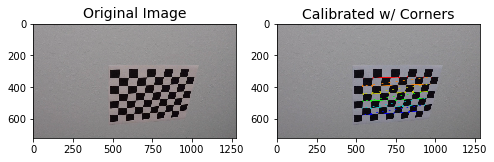

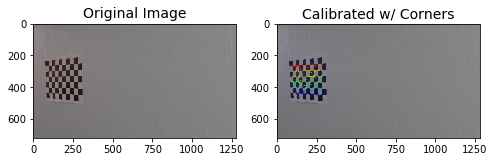

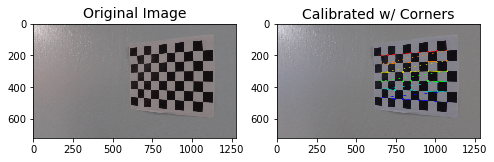

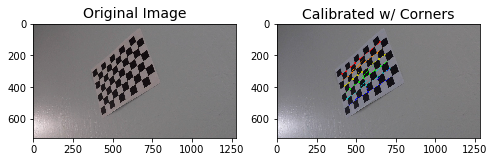

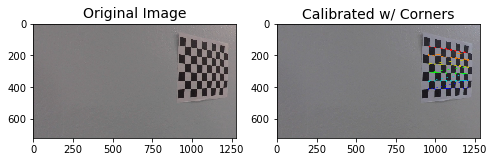

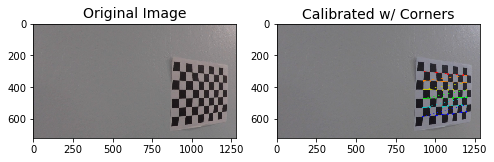

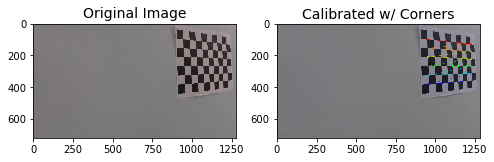

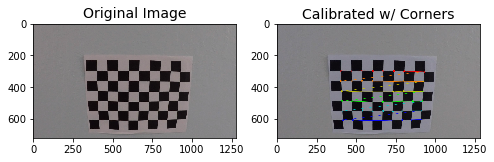

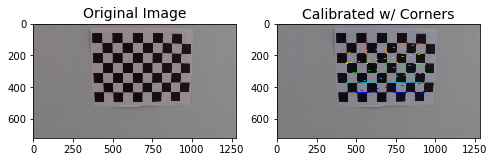

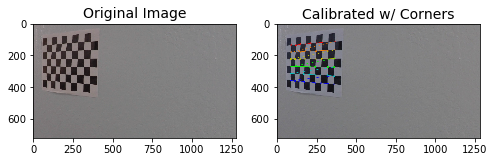

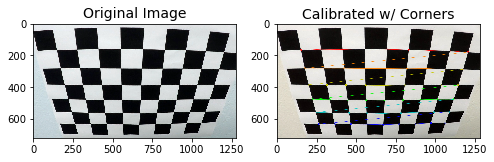

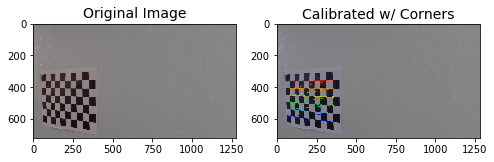

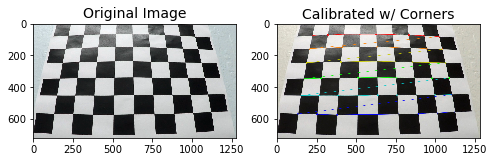

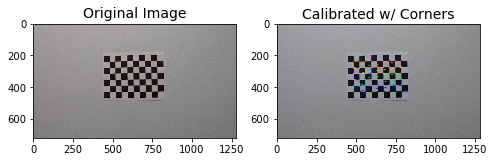

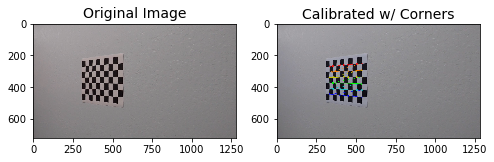

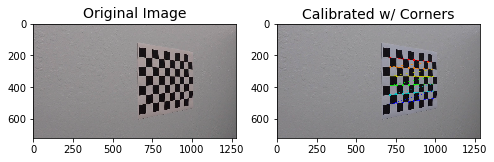

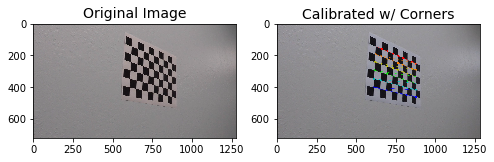

In [1]:
# find cornors

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline


# create array for trageted area
objpoint = np.zeros((6*9,3), np.float32)
objpoint[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
objpoints = []           # 3d points in object space
imgpoints = []           # 2d points in image plane.

img = glob.glob('camera_cal/calibration*.jpg')

for idx, filename in enumerate(img):
    images = cv2.imread(filename)
    grayed = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(grayed, (9,6), None)

    # add object points, image points to created array
    if ret == True:
        objpoints.append(objpoint)
        imgpoints.append(corners)

        # draw and display corners overlayed
        cv2.drawChessboardCorners(images, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(filename), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=14)
        ax2.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
        ax2.set_title('Calibrated w/ Corners', fontsize=14)

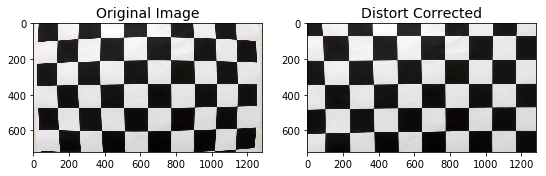

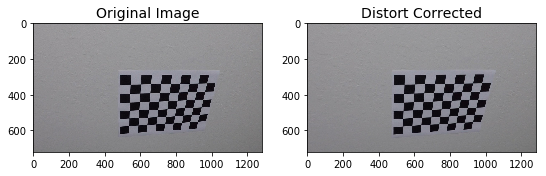

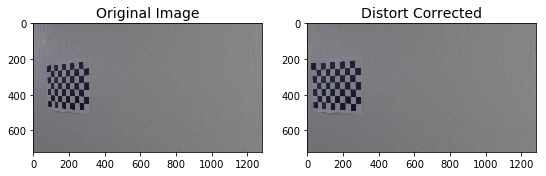

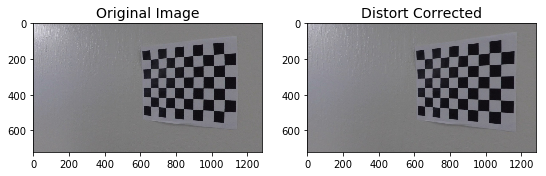

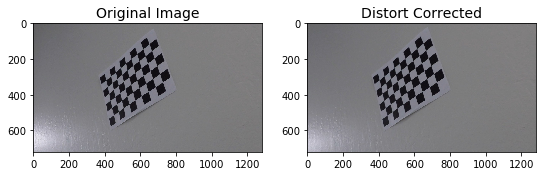

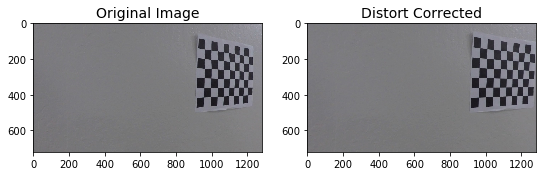

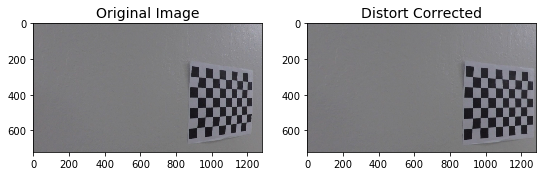

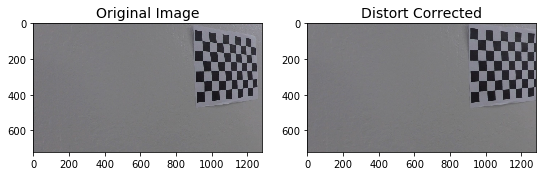

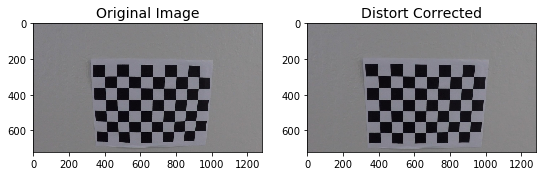

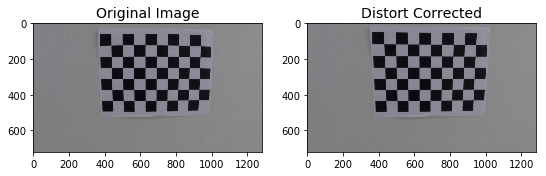

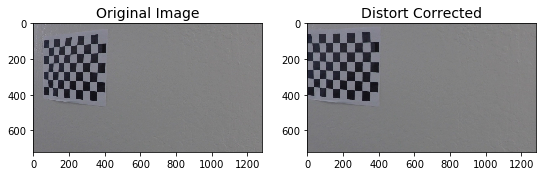

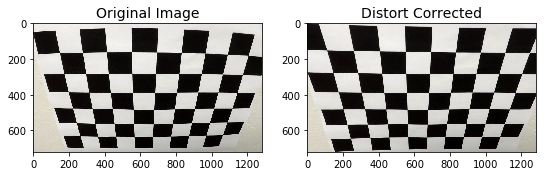

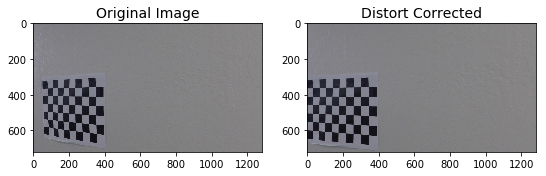

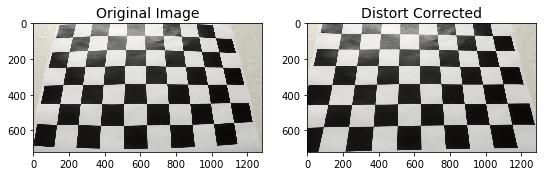

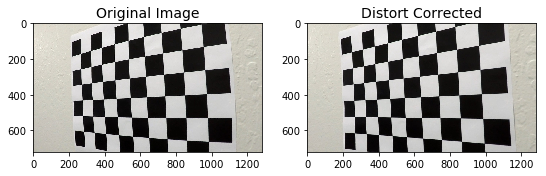

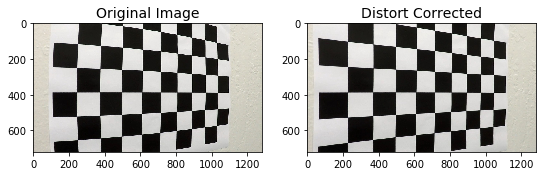

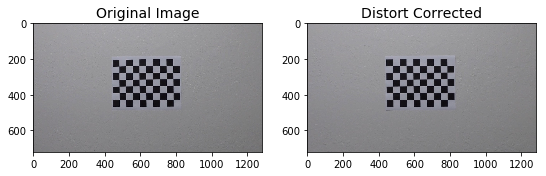

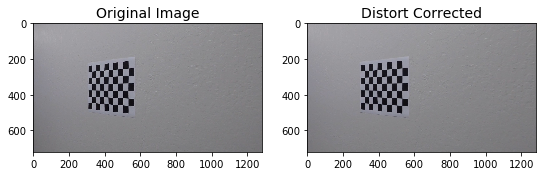

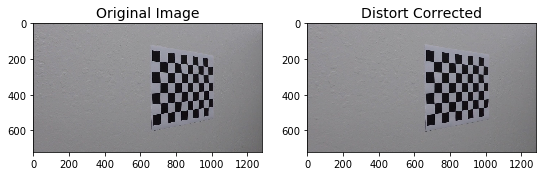

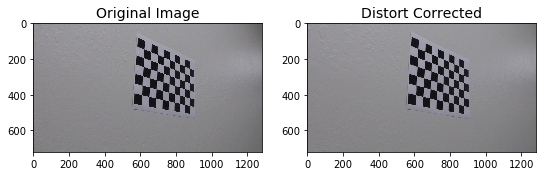

In [2]:
# undistort images

def undistortimg(image, display = True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=14)
        ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax2.set_title('Distort Corrected', fontsize=14)
    else:
        return undistorted
    
imgdis = glob.glob('camera_cal/calibration*.jpg')
for image in imgdis:
    undistortimg(image)

### 2. Perspective Transform

The second part of this project: I have composed a function transforming the undistorted image to a bird’s-eye view of the road which will be useful for calculating the lane curvature later on.

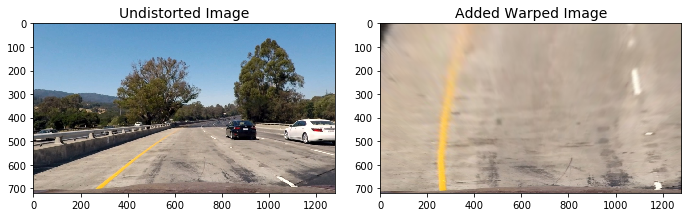

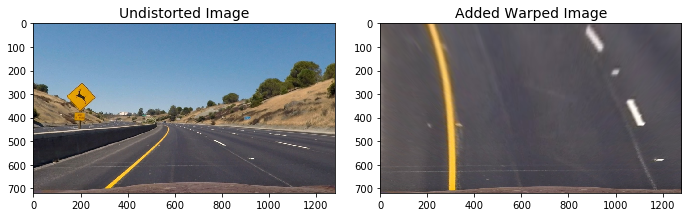

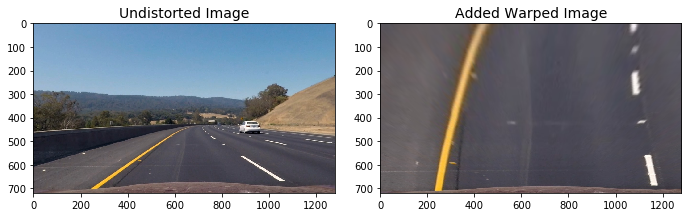

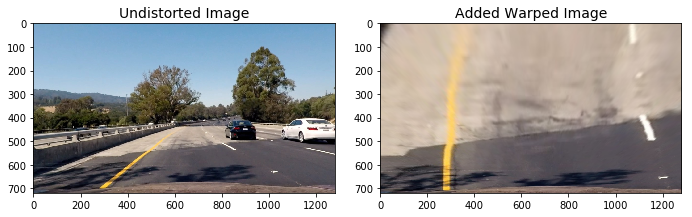

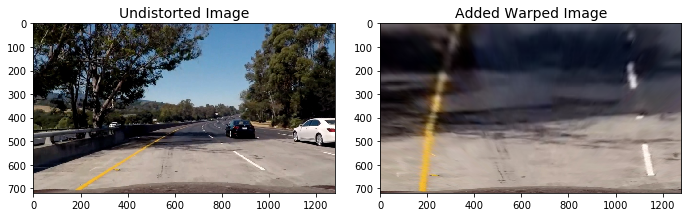

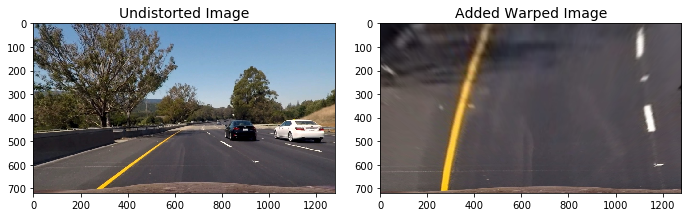

In [3]:
# define area of interest
targeted_area = [[550,460],[750,460],
                    [1150,720],[90,720]]

def warpedimg(image, display = True, read = True):
    if read:
        undistorted = undistortimg(image, display = False)
    else:
        undistorted = undistortimg(image, display = False, read=False)
    
    img_size = (undistorted.shape[1], undistorted.shape[0])
    src = np.float32(targeted_area)
    
    offset1 = 100            # offset for dst points x value
    offset2 = 0              # offset for dst points bottom y value
    offset3 = 0              # offset for dst points top y value
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=14)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Added Warped Image', fontsize=14)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M
    
for image in glob.glob('test_images/test*.jpg'):
    warpedimg(image)

### 3. Gradient Threshold

The third part of this project, I tried to convert the warped image to create gradient thresholded images which highlight only the lane lines and ignore the rest of images. Among colorspace, the following channels provide somewhat acceptable testing images:

* Saturation S Channel from the HLS color space, with a threshold of 180-255, identified both the white and yellow lane lines, but did not take 100% of the pixels in either one, and had a tendency to get distracted by dark spots on the road.
* Lightness L Channel from the LUV color space, with a threshold of 225-255, picked up the white lane lines, but completely discarded the yellow lines.
* Blue-yellow B channel from the Lab color space, with a threshold of 155-200, identified the yellow lines, but completely discarded the white lines.

The solution is to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

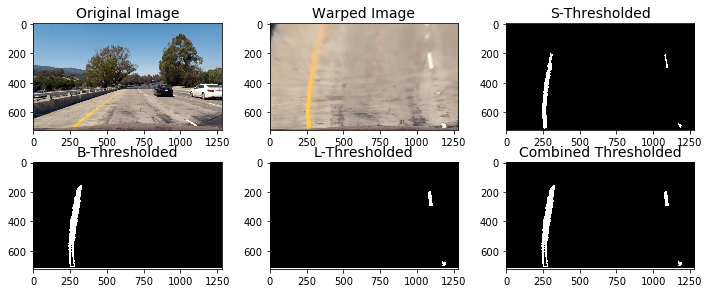

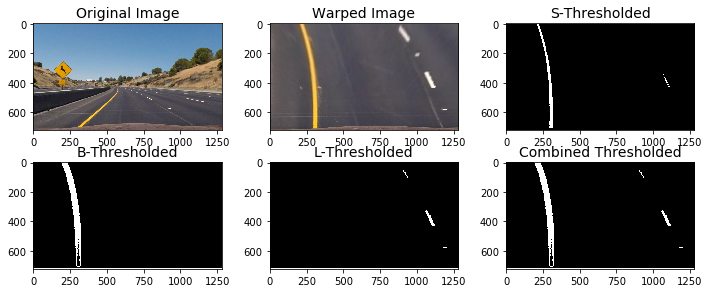

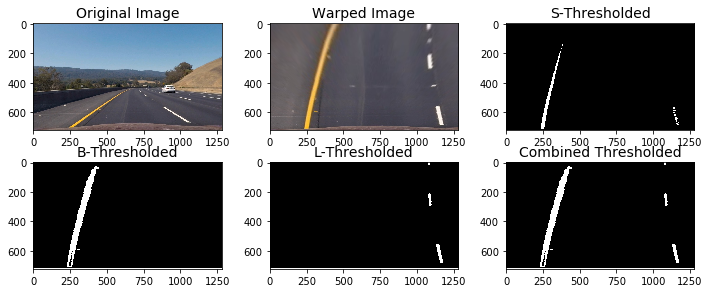

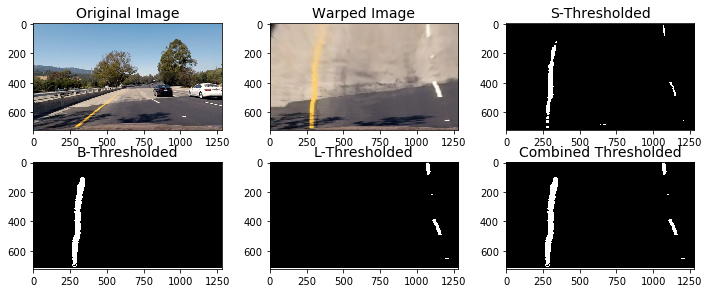

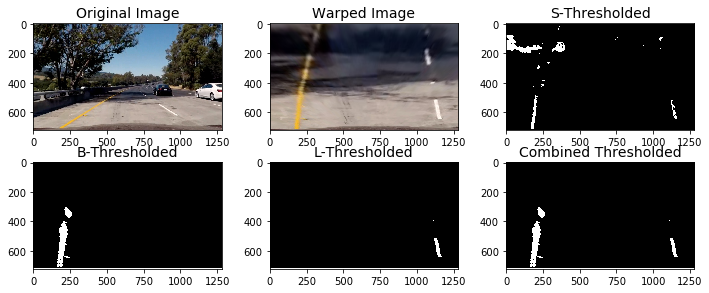

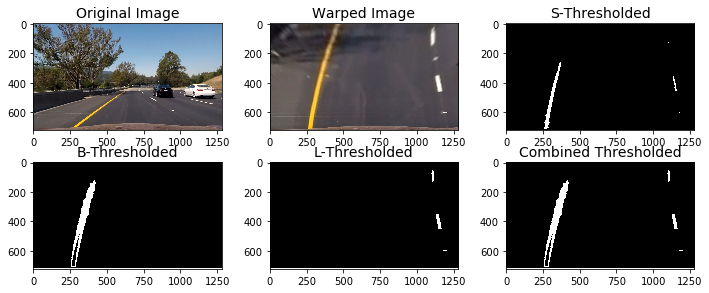

In [4]:
def thresholdsimg(image, display=True):
    img, M = warpedimg(image, display = False)

    # seperate the color channels
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if display == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=14)
        ax1.imshow(cv2.cvtColor(undistortimg(image, display=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=14)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('S-Thresholded', fontsize=14)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('B-Thresholded', fontsize=14)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('L-Thresholded', fontsize=14)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined Thresholded', fontsize=14)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary
    

for image in glob.glob('test_images/test*.jpg'):
    thresholdsimg(image)

### 4. Still Image - Polyfit Lane Line, Determine Car Position and Calculate Radius of Curvature

This part of this project reqires me to use the combined binary image to isolate and polyfit lane lines. The position of the car was measured by taking the mean value of the x intercepts of each line. The equation for calculating radius of curvature was referenced online.

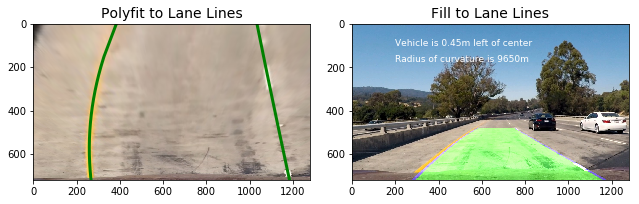

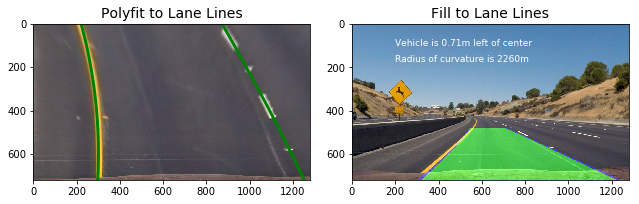

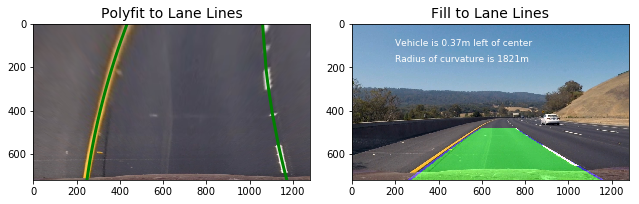

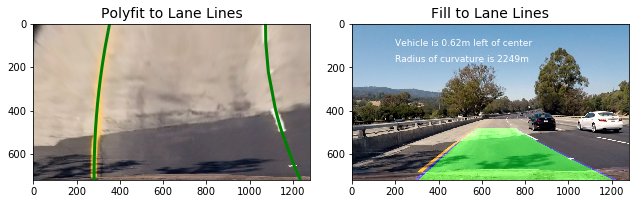

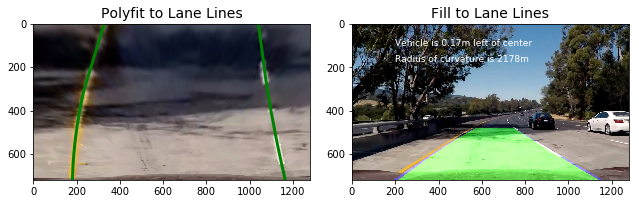

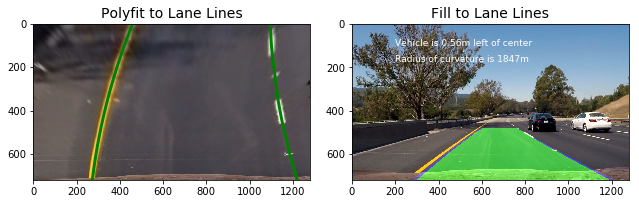

In [5]:
# define area of interest
targeted_area = [[550,460],[750,460],
                    [1150,720],[90,720]]

def find_lane(image):
    
    combined_binary = thresholdsimg(image, display=False)
    
    # create array for line points
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 620
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    # define area of interest
    targeted_area = [[490, 480],[810, 480],
                      [1250, 720],[40, 720]]
    src = np.float32(targeted_area)
    offset1 = 0              # offset for dst points x value
    offset2 = 0              # offset for dst points bottom y value
    offset3 = 0              # offset for dst points top y value
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((warpedimg(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Polyfit to Lane Lines', fontsize=14)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill to Lane Lines', fontsize=14)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='normal', color='white', fontsize=9)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='normal', color='white', fontsize=9)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='normal', color='white', fontsize=9)


for image in glob.glob('test_images/test*.jpg'):
    find_lane(image)

### 5. Video - Polyfit Lane Line, Determine Car Position and Calculate Radius of Curvature

This part of this project reqires me to process the video using the same methods above for still images.

In [6]:
# prepare video process
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        When the lane lines have been detected in the previous frame.
        A sliding window searches for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        Within the first few frames and/or if the lane was not successfully detected in the previous frame.
        A slinding window approaches to detect peaks in a histogram of the binary thresholded image. 
        Pixels in close proimity to the detected peaks are considered to belong to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720            # meters per pixel in y dimension
        xm_per_pix = 3.7/700            # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
    
# process video pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # initiate perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # create binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # pick thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # pick thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # combine binary images
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True:              # search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True:             # search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False:            # perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:             # perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # calculate average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # append averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # polyfit to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # calculate average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # polyfit to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # calculate radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # display radius of curvature only every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # calculate vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # display distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # display radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

# load the video
Left = Line()
Right = Line()
clip1 = VideoFileClip("project_video.mp4").subclip(0,50)

# start to process video
white_clip = clip1.fl_image(process_vid) 
video_output = 'project_video_result.mp4'
white_clip.write_videofile(video_output, audio=False)

# play processed video in browser
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_result.mp4'))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1250/1251 [15:50<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

